# This Looks Like That There
General plots for the paper.

In [1]:
import os
import sys
import imp 

import numpy as np
from tqdm import tqdm
from tqdm import trange
from icecream import ic          # pip install icecream
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cmasher as cmr            # pip install cmasher

import cartopy as ct

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

import warnings
warnings.filterwarnings( "ignore", module = "cartopy\..*" )
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "23 November 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 400.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.4 (default, Apr  9 2021, 09:32:38) 
[Clang 10.0.0 ]
numpy version = 1.20.1
tensorflow version = 2.5.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'quadrants'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)


## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
DOUBLE_CONV          = settings['double_conv']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_EPOCH_BOUND       = 10000
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

In [9]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR  = settings['data_dir']
STAGE     = settings['analyze_stage']

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
    

loading ./data/data_quadrants.mat
shuffling the data before train/validation/test split.
raw_data        = (9000, 100, 100, 1)
training data   = (7200, 100, 100, 1), (7200,)
validation data = (1800, 100, 100, 1), (1800,)
test data       = (0, 100, 100, 1), (0,)
X_mean          = -8.325328964462919e-05
X_std           = 0.1127845155013707


In [11]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 
            
# adjust_spines(ax, ['left', 'bottom'])
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.spines['left'].set_color('dimgrey')
# ax.spines['bottom'].set_color('dimgrey')
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)            

In [12]:
# raise ValueError('here')

## QUADRANTS

In [13]:
i = np.where([y_train==0])[0]
j = np.where([y_val==0])[0]
print(len(i)+len(j))

i = np.where(y_train==1)[0]
j = np.where([y_val==1])[0]
print(len(i)+len(j))

i = np.where(y_train==2)[0]
j = np.where([y_val==2])[0]
print(len(i)+len(j))


3000
3000
3000


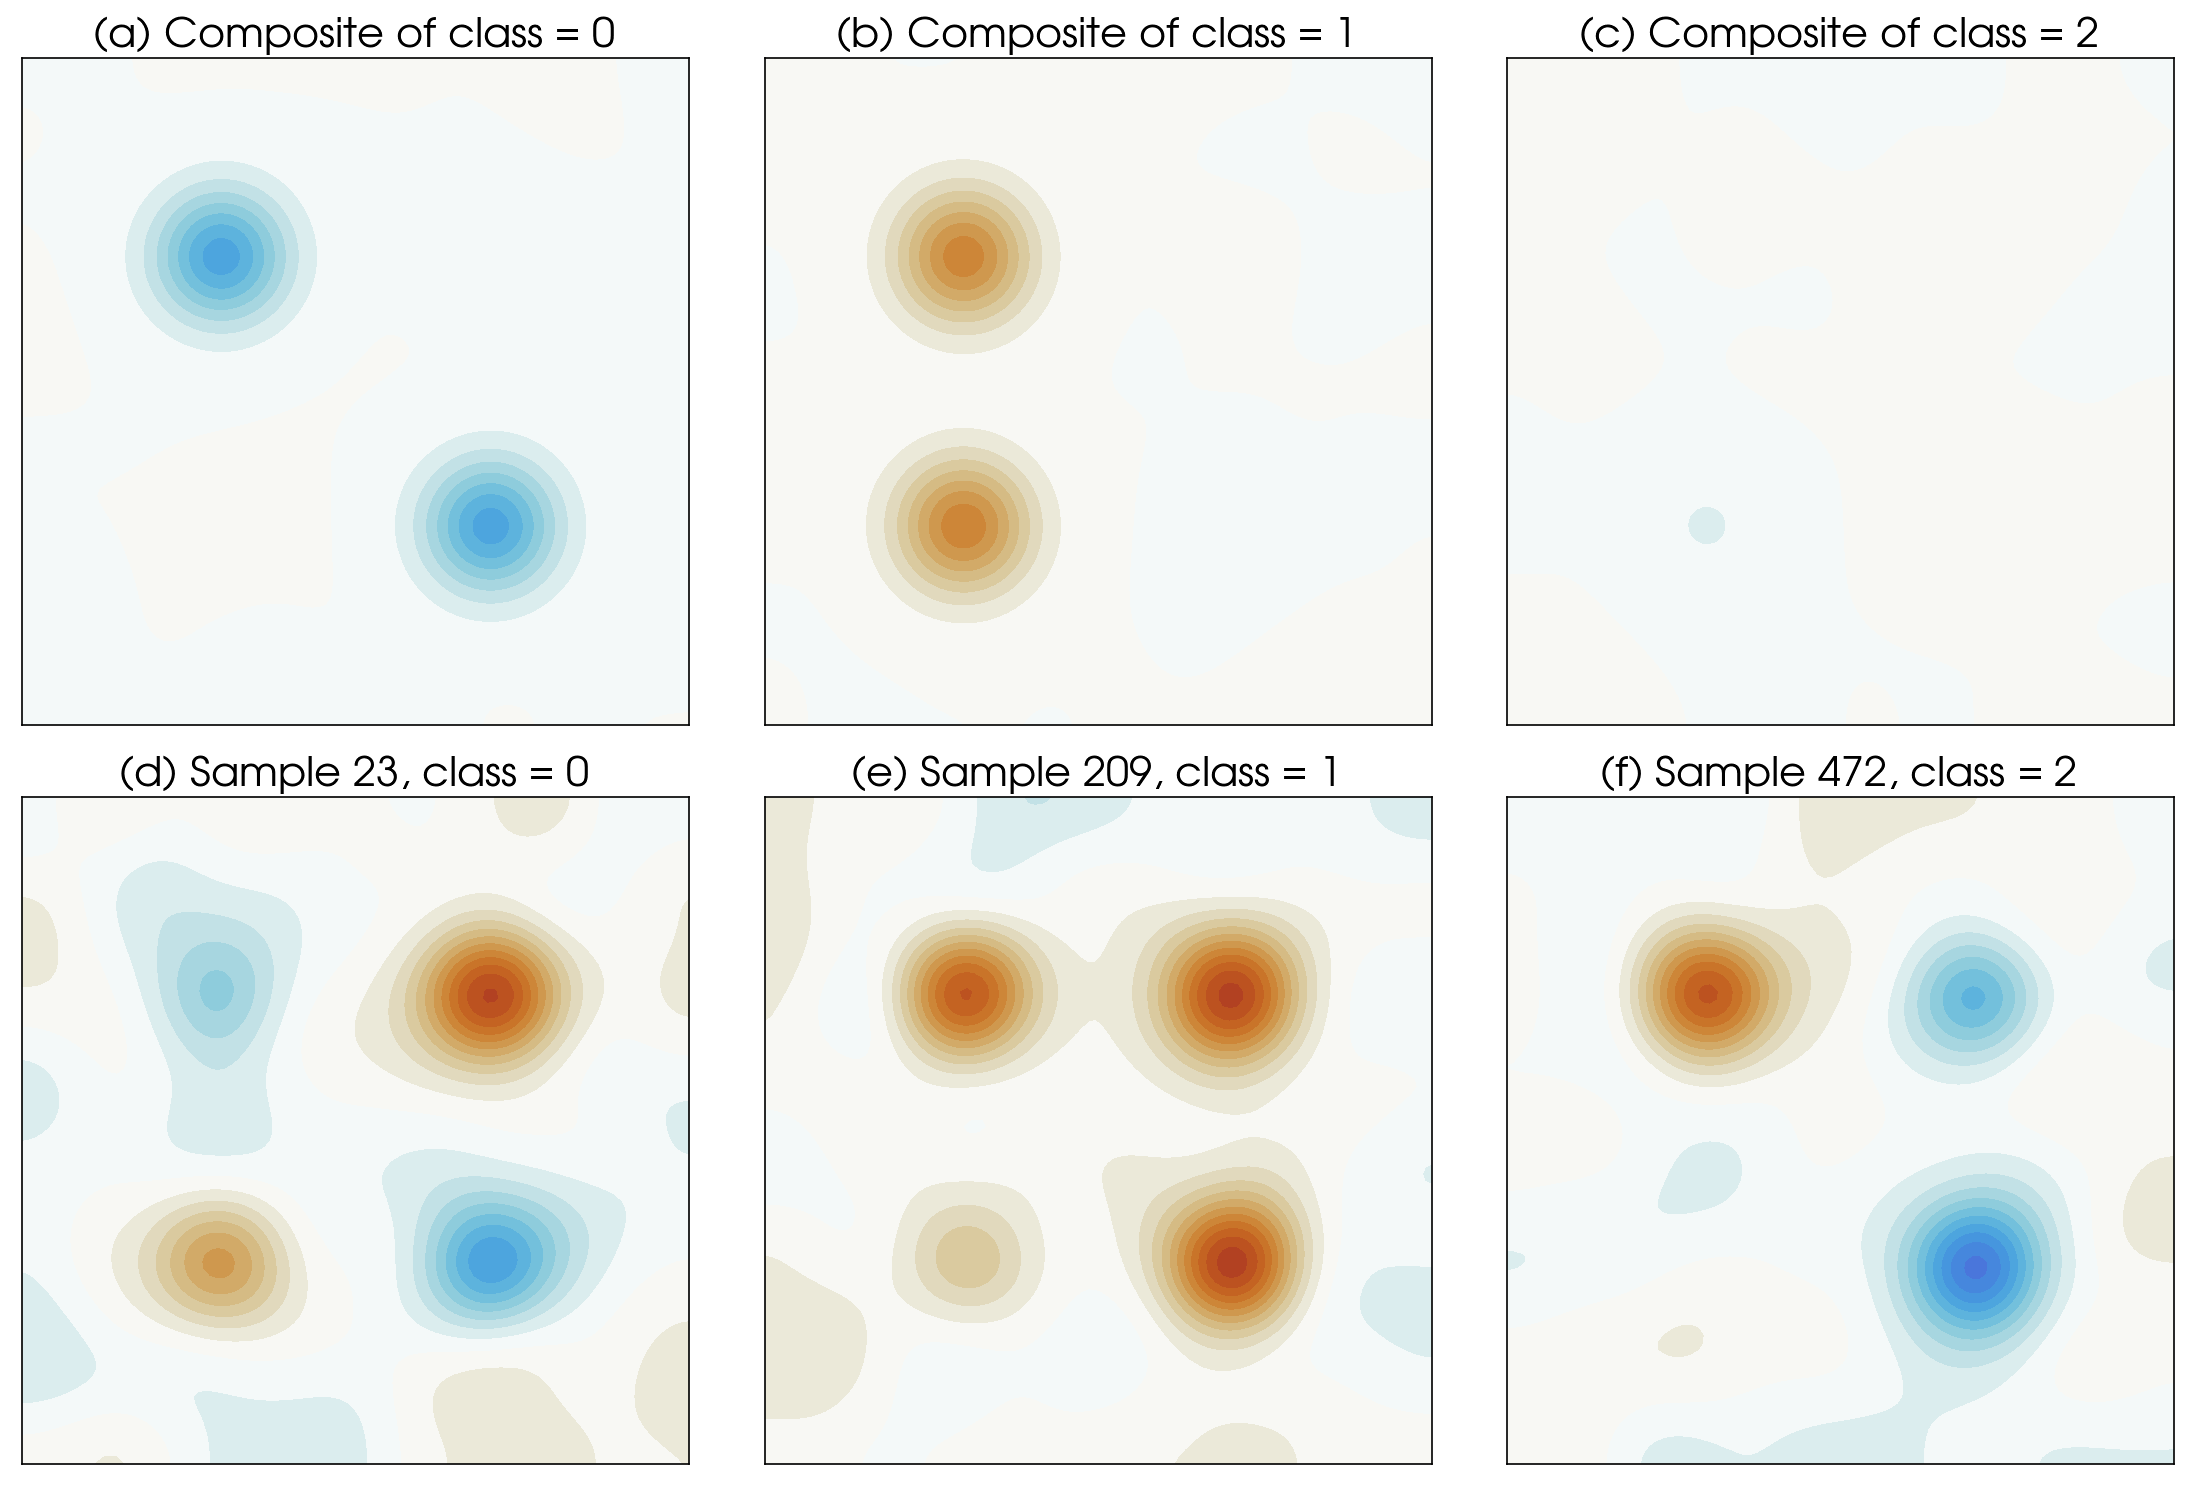

In [14]:
# sample_num = (208,209,472)
sample_num = (23,209,472)

plt.figure(figsize=(15,10))
ax = plt.gca()

for label in (0,1,2):
    for example in (0,1):
        index = np.where(y_train==label)[0]
        if example==0:
            letters = ('(a)','(b)','(c)')
            plot_data = np.mean(X_train[index,:,:,0],axis=0)
            title = letters[label] + ' Composite of class = ' + str(label)
        else:
            letters = ('(d)','(e)','(f)')            
            plot_data = X_val[sample_num[label],:,:,0]
            title = letters[label] + ' Sample ' + str(sample_num[label]) + ', class = ' + str(label)
    
        plt.subplot(2,3,(label+1)+3*example,aspect='equal')
        plt.contourf(plot_data, levels = np.arange(-10., 10.5, .5), cmap='cmr.fusion_r')
        plt.title(title, fontsize=20)
        plt.xticks([])
        plt.yticks([])

plt.tight_layout() 
plt.savefig((vizualization_dir + EXP_NAME + '_composites_examples_of_classes.png'), dpi=dpiFig)
plt.show()    

## MJO

In [ ]:
import pandas as pd
df = []
df_val = []

df = pd.DataFrame(data={'phase': y_train, 'Split':'training'})
df_val = pd.DataFrame(data={'phase': y_val, 'Split':'testing'})
df = df.append(df_val,ignore_index=True)

plt.figure()
g = sns.histplot(data=df, x="phase", hue="Split", 
             multiple="dodge", 
             stat='count',
             bins=np.arange(-.5,10.5),
             discrete=True,
             shrink=.8,
             legend=True,
            )
plt.ylim(0,5500)
plt.xticks(np.arange(0,9),np.arange(0,9))
plt.yticks(np.arange(0,6000,1000),np.arange(0,6000,1000))
plt.title('MJO Samples by Label')

plt.tight_layout() 
plt.savefig((vizualization_dir + EXP_NAME + '_sample_counts_split.png'), dpi=dpiFig)
plt.show()    